# Libs

In [48]:
suppressPackageStartupMessages({
    library(tessera)

    ## Downstream analysis in Seurat V5
    library(Seurat)

    ## Plotting functions 
    ## Not imported by Tessera
    library(ggplot2)
    library(ggthemes)
    library(viridis)
    library(patchwork)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}



# Data

Small sample MERFISH dataset from Chen et al: 

https://www.biorxiv.org/content/10.1101/2023.04.04.535379v1.abstract


In [49]:
data('tessera_warmup')
counts = tessera_warmup$counts
meta_data = tessera_warmup$meta_data
meta_vars_include = c('type')


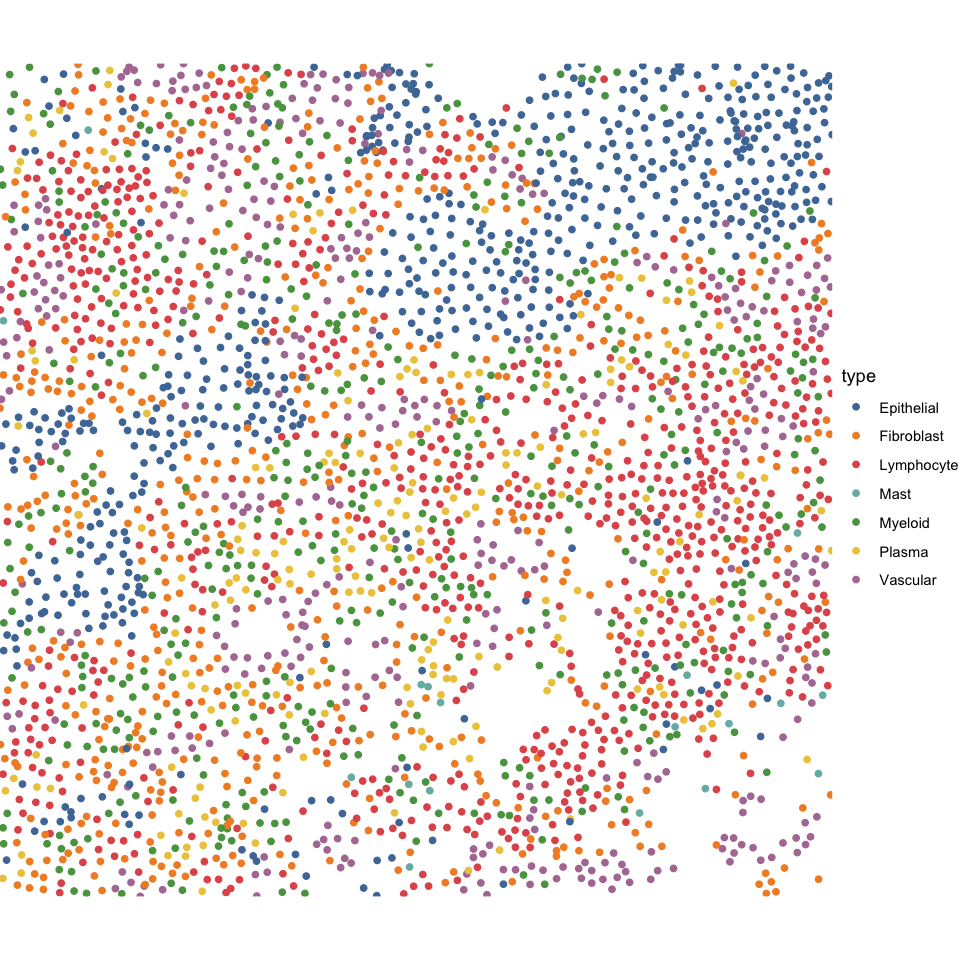

In [50]:
fig.size(8, 8)
ggplot() + 
    geom_point(data = meta_data, aes(X, Y, color = type)) + 
    theme_void() + 
    scale_color_tableau() + 
    coord_sf(expand = FALSE) + 
    NULL


Some coarse grained cell types are predefined here, to help interpret the tiles we get below. 

In [51]:
table(meta_data$type)


Epithelial Fibroblast Lymphocyte       Mast    Myeloid     Plasma   Vascular 
       634        588        829         18        491        206        411 

# Get Tiles

Run the Tessera algorithm to get tiles in one function. The result is returns in two structures: 

1) dmt: cell-level information. 
2) aggs: tile-level information. 

The two are tied together through `dmt$pts$agg_id`


In [52]:
res = GetTiles(
    X = meta_data$X, 
    Y = meta_data$Y, 
    counts = counts, 
    meta_data = meta_data, 
    meta_vars_include = meta_vars_include,
)
dmt = res$dmt
aggs = res$aggs


STEP 0: PREPARE DATA STRUCTURES

STEP 1: GRADIENTS 

STEP 2: DMT

STEP 3: AGGREGATION



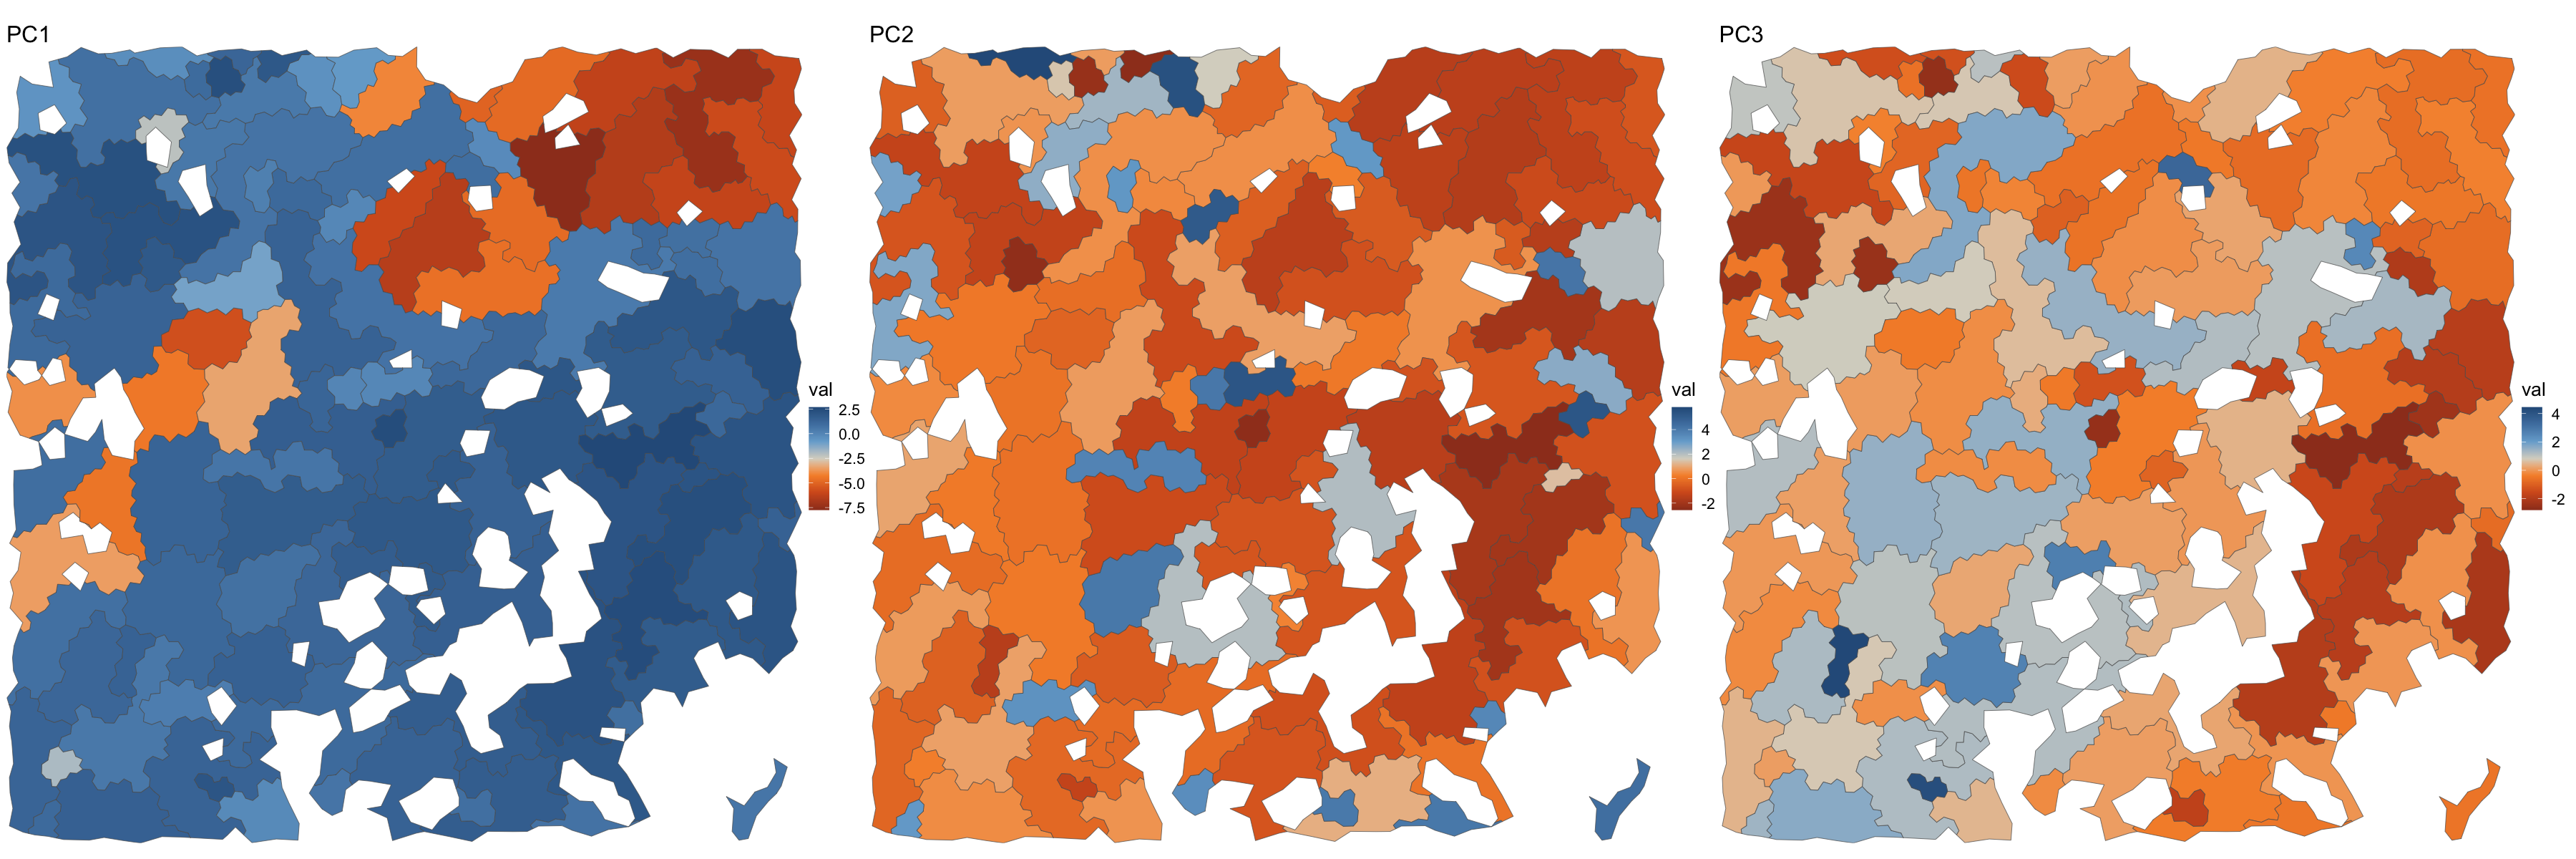

In [53]:
fig.size(10, 30)
purrr::map(1:3, function(i) {
    ggplot(cbind(aggs$meta_data, val=aggs$pcs[, i])) + 
        geom_sf(aes(geometry = shape, fill = val)) + 
        theme_void(base_size = 16) + 
        coord_sf(expand = FALSE) + 
        scale_fill_gradient2_tableau() + 
        guides(color = 'none') + 
        labs(title = paste0('PC', i)) + 
        NULL 
}) %>% 
    purrr::reduce(`|`)


# Cluster and label tiles 

Let's treat each aggregate as a unit of analysis. 


In [54]:
obj = Seurat::CreateSeuratObject(
    counts = aggs$counts, 
    meta.data = tibble::column_to_rownames(data.frame(dplyr::select(aggs$meta_data, -shape)), 'id')
)

## Seurat doesn't do sf shapes well 
obj@meta.data$shape = aggs$meta_data$shape

## Represent each tile as the mean PC embeddings of all its cells 
## NOTE: this tends to produce more biologically meaningful results than pooling gene counts per tile 
rownames(aggs$pcs) = colnames(obj)
obj[['pca']] = Seurat::CreateDimReducObject(embeddings = aggs$pcs, loadings = dmt$udv_cells$loadings, key = 'pca_', assay = Seurat::DefaultAssay(obj))

Do all the typical steps for Seurat clustering. 

In [55]:
.verbose = FALSE
obj = obj %>% 
    NormalizeData(normalization.method = 'LogNormalize', scale.factor = median(obj@meta.data$nCount_RNA), verbose = .verbose) %>% 
    RunUMAP(verbose = .verbose, dims = 1:10, reduction = 'pca') %>% 
    Seurat::FindNeighbors(features = 1:10, reduction = 'pca', verbose = .verbose) %>% 
    Seurat::FindClusters(verbose = .verbose, resolution = c(2))


Let's see the aggregate clusters in UMAP and physical space. 

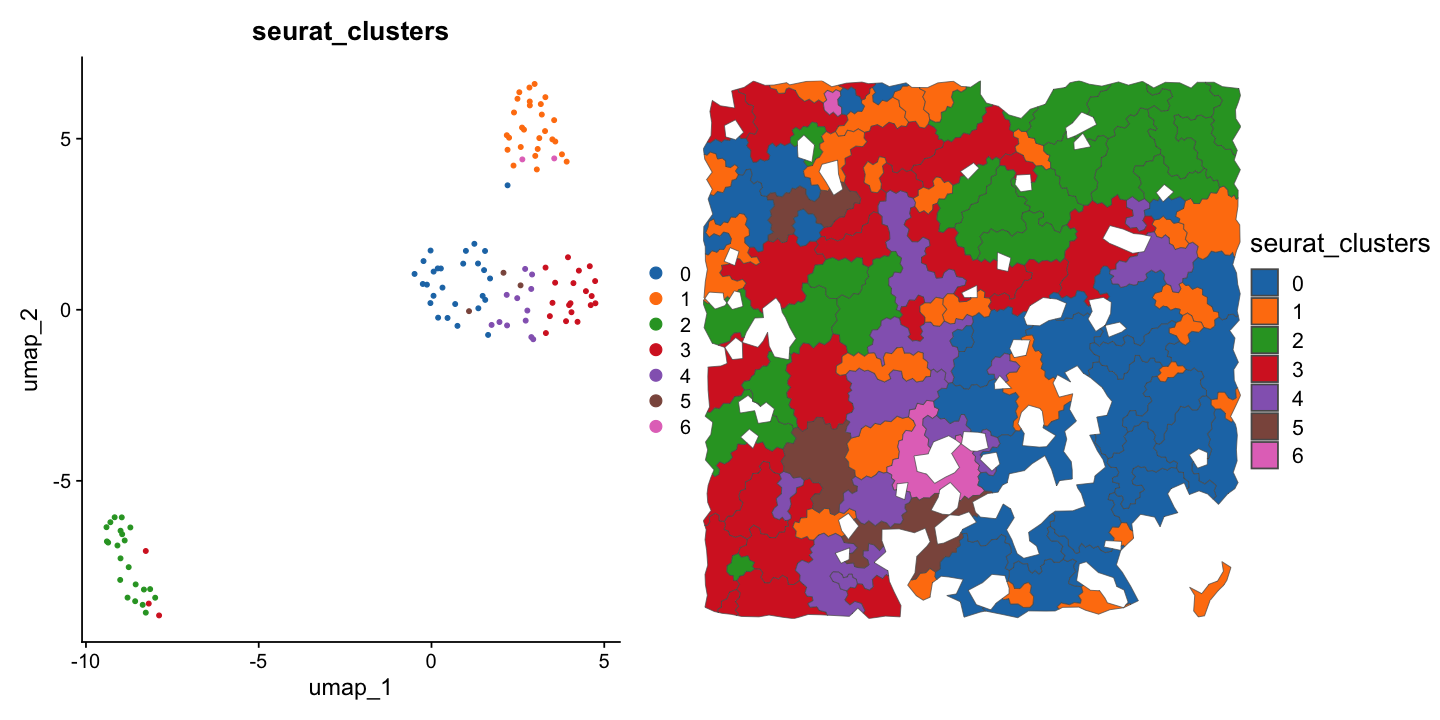

In [56]:
p1 = DimPlot(obj, reduction = 'umap', group.by = 'seurat_clusters') + scale_color_tableau('Classic 10') 
p2 = ggplot(obj@meta.data) + 
    geom_sf(aes(geometry = shape, fill = seurat_clusters)) + 
    theme_void(base_size = 16) + 
    coord_sf(expand = FALSE) + 
    scale_fill_tableau('Classic 10') + 
    NULL 

fig.size(6, 12)
(p1 | p2) + plot_layout(widths = c(1, 1))

# Transfer agg information to cells

In [57]:
dmt$pts$spatial_cluster = obj@meta.data$seurat_clusters[dmt$pts$agg_id]

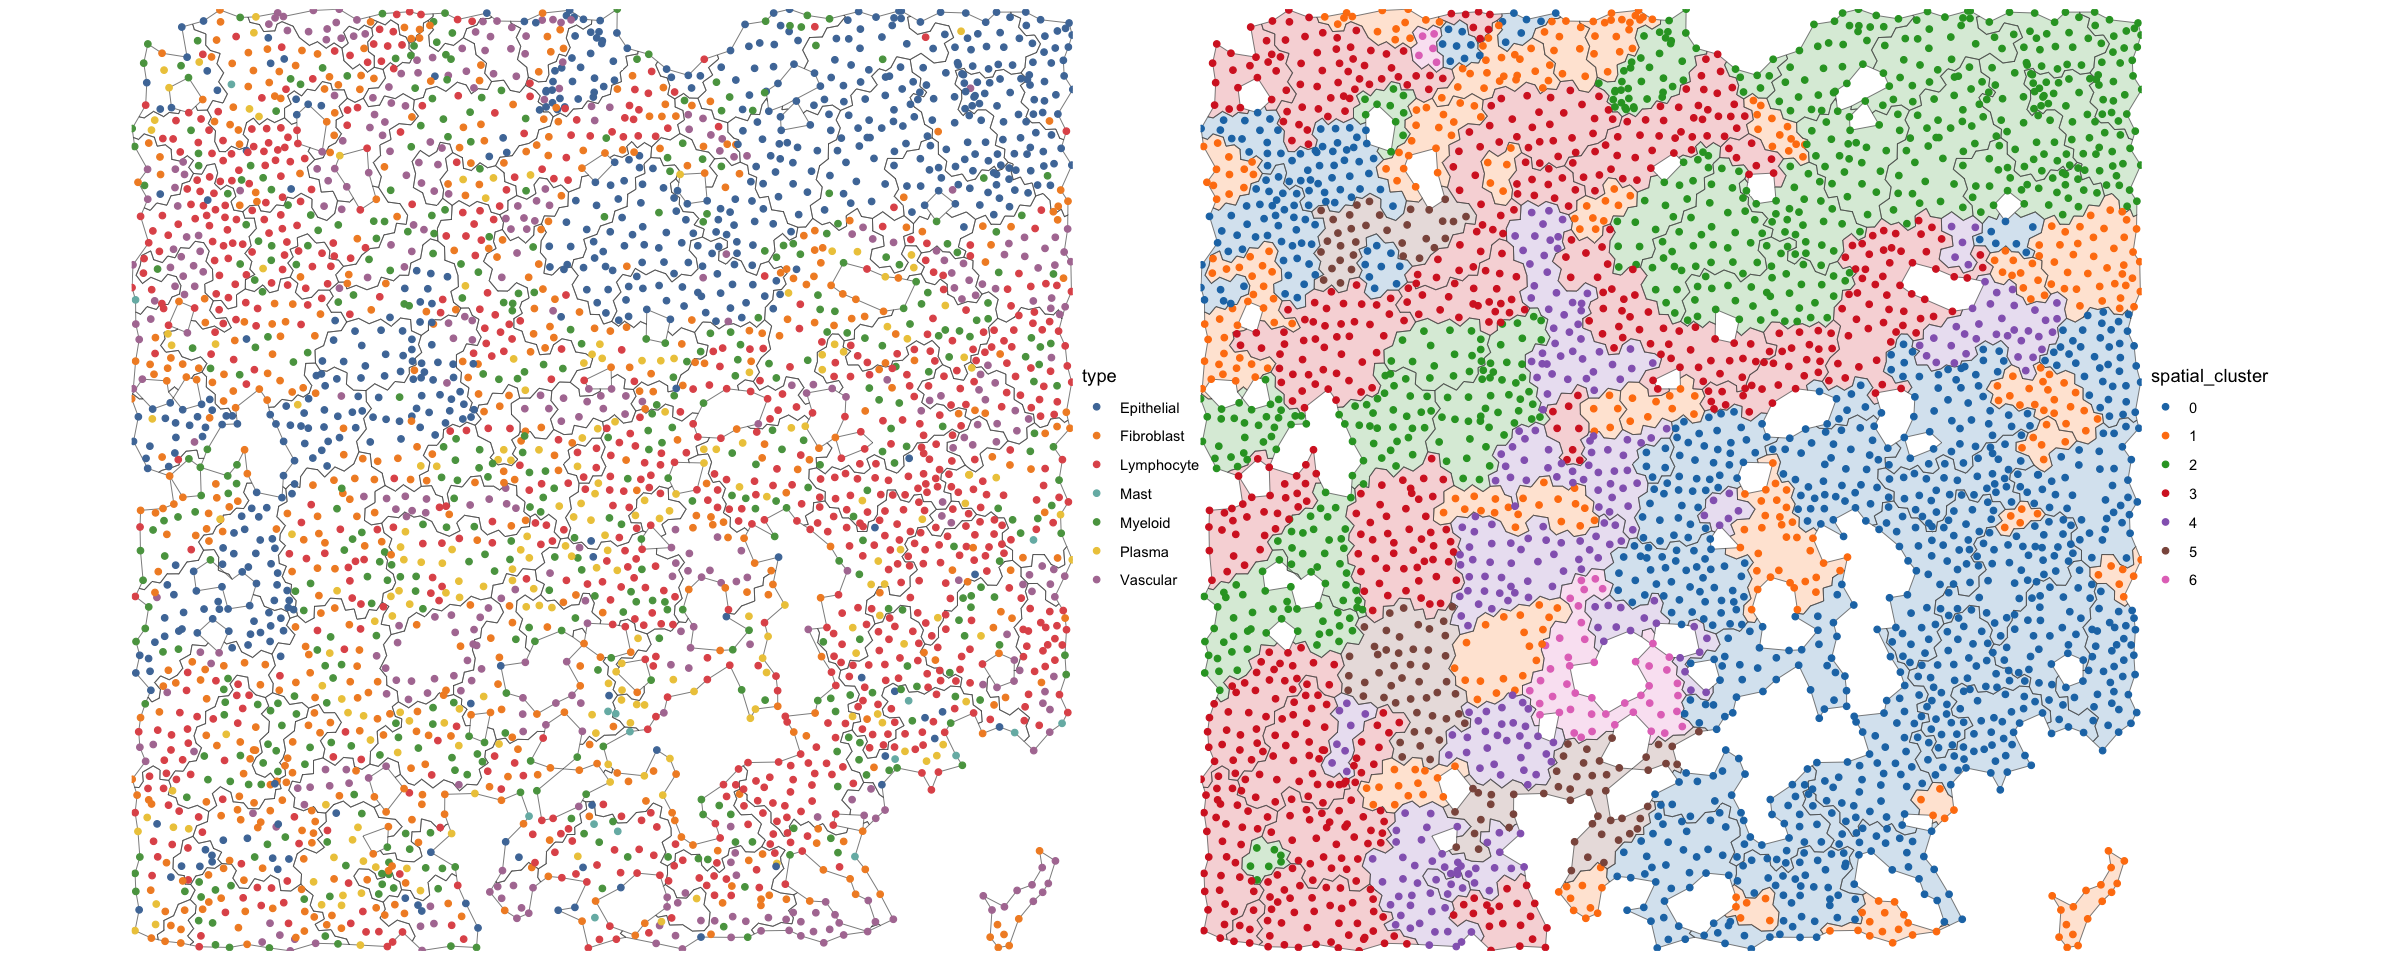

In [58]:
p1 = ggplot() + 
    geom_sf(data = obj@meta.data, aes(geometry = shape), fill = NA) + 
    geom_point(data = dmt$pts, aes(X, Y, color = type)) + 
    scale_color_tableau() + 
    theme_void() + 
    coord_sf(expand = FALSE) + 
    NULL
p2 = ggplot() + 
    geom_sf(data = obj@meta.data, aes(geometry = shape, fill = seurat_clusters), alpha = .2) + 
    geom_point(data = dmt$pts, aes(X, Y, color = spatial_cluster)) + 
    scale_color_tableau('Classic 10') + 
    scale_fill_tableau('Classic 10') + 
    theme_void() + 
    guides(fill = 'none') + 
    coord_sf(expand = FALSE) + 
    NULL
fig.size(8, 20)
p1 | p2


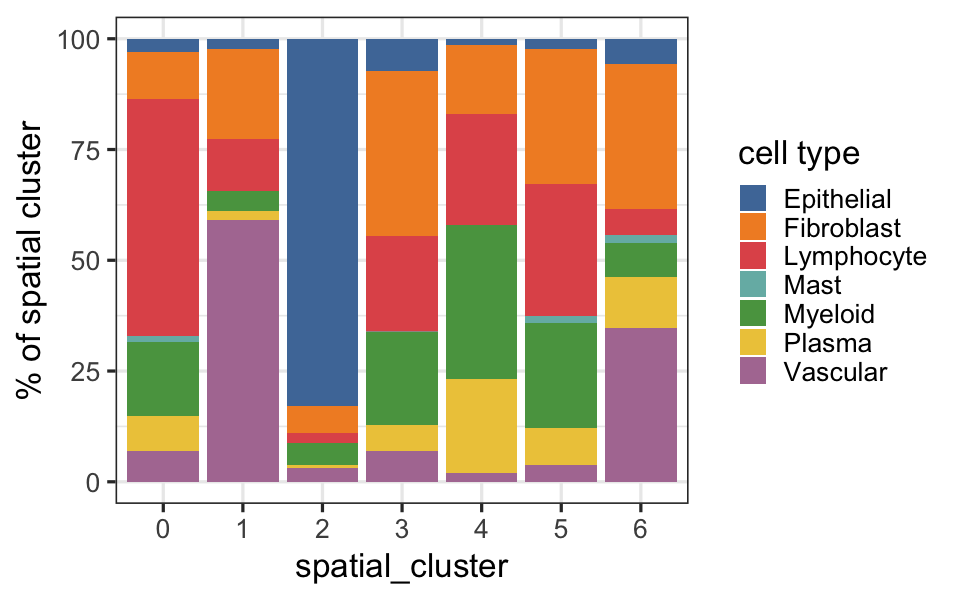

In [73]:
dmt$pts %>% 
    with(table(type, spatial_cluster)) %>% 
    prop.table(2) %>% 
    data.table() %>% 
    ggplot(aes(spatial_cluster, 100 * N, fill = type)) + 
        geom_bar(stat = 'identity', position = position_stack()) + 
        scale_fill_tableau() + 
        theme_bw(base_size = 20) + 
        labs(y = '% of spatial cluster', fill = 'cell type') + 
        NULL


We can also query genes in space as we usually do in cells. 

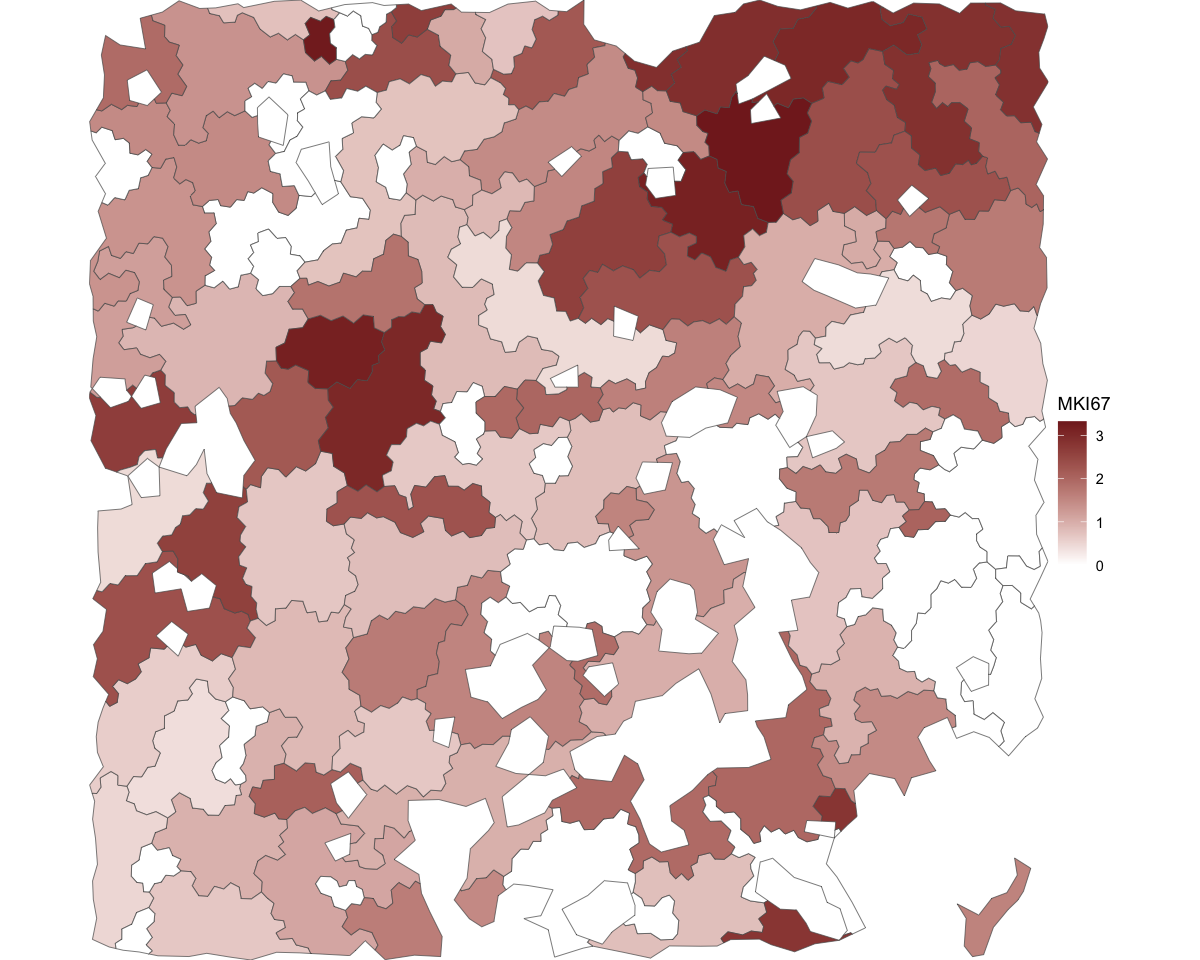

In [113]:
feature = 'MKI67' ## dividing cells 
# feature = 'CD3E' ## T cells 

fig.size(8, 10)
ggplot() + 
    geom_sf(data = cbind(obj@meta.data, FetchData(obj, feature)), aes(geometry = shape, fill = !!sym(feature))) + 
    scale_fill_gradient(low = 'white', high = '#832424') + 
    theme_void() + 
    coord_sf(expand = FALSE) + 
    NULL

